<img src="introduction.PNG">

# Introduction

In this notebook, the machine learning model, $\psi$, has already been deployed as a web-service in Azure ML Studio. Here, we 
test that endpoint for a couple separate purposes. First, we switch up actors in an existing movie from the validation
set to see how that affects the resulting revenue predictions. Maybe we could have had
a bigger payout with a different lead actor. Second, we pull in the dataset representing the 
box-office for a single weekend (perhaps the upcoming weekend), send that data to the web-service for predictions, 
and plot those results.

# Get a Single Prediction

Input - Single predictions: Deployed web-service $\psi$
    
Hit the web-service to get a revenue prediction for a single movie on a single weekend at the box-office.

Output: JSON from the deployed web-service.

In [4]:
import urllib.request as urlr
import urllib.error as urle
from bs4 import BeautifulSoup
import json 

# function takes a single row
def get_prediction(values):

    data =  {

            "Inputs": {

                    "input1":
                    {
                        "ColumnNames": ["Column 0", "rank", "something", "movie", "distributor", "gross", "change", "theatres", "per_theatre", "total_gross", "days", "date", "year", "month", "day", "actor1", "actor2", "actor3", "actor4", "actor5", "runtime", "rating", "genre", "release_type", "previous_week_gross", "previous_week_theaters"],
                        "Values": [ values, ]
                    },        },
                "GlobalParameters": {
    }
        }

    body = str.encode(json.dumps(data))
    url = 'https://ussouthcentral.services.azureml.net/workspaces/5a180e28a51643f38d3b63f026020c7d/services/2ae431ee3f04439cbe82b2accd648b6a/execute?api-version=2.0&details=true'
    api_key = 'QdK/PrSYa1Gy3jeNtDBJvmC88RkRi8+jXtSokOIm/i9KYQc4xgQu5VM9e+DBk5qTUXjG5tXK6AQ1LNo4Zlrprw==' # Replace this with the API key for the web service
    headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

    req = urlr.Request(url, body, headers) 
    try:
        response = urlr.urlopen(req)
        result = response.read()
        soup = BeautifulSoup(result, "lxml")
        text = json.loads(result)
        retArray = text['Results']['output1']['value']['Values'][0]
        ret = retArray[len(retArray) - 1]
        return ret
    except urle.HTTPError:
        print("The request failed with status code: " + str(error.code))

        # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
        print(error.info())

        print(json.loads(error.read()))                 

In [5]:
values = [ "4701","7","-5","Why Him?","20th Century Fox","6901730","-0.31","2904","2377","48961283","17","1/6/2017 0:00","2017","1","6","Dev Patel","James Franco","Zoey Deutch","Megan Mullally","Cedric the Entertainer","111","R","Comedy","Wide","10048645","3008" ]
get_prediction(values)

'5339045.57761831'

# Get results for a single movie on a given date with multiple lead actors

It might be interesting for a studio to analyze what could have been if they had cast different actors in the lead role. 
Perhaps a similar model could be built and applied during the casting period of a movie before it is filmed and released.

Input - Single movie, different actor predictions: box_office_validation_predictions_actors.csv

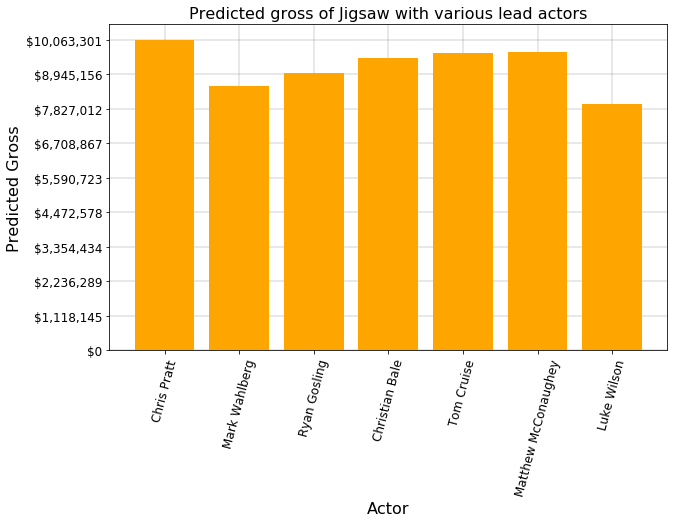

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# read the data output with predictions and actuals from csv
data = pd.read_csv('box_office_validation_predictions_actors.csv', sep=',',header=0)

# look at a single movie for a single weekend with multiple actors in the lead role
movie = 'Jigsaw'
week = '11/3/2017 12:00:00 AM';
actors = ['Chris Pratt', 'Mark Wahlberg', 'Ryan Gosling', 'Christian Bale', 'Tom Cruise', 'Matthew McConaughey', 'Luke Wilson']

# remove all weeks but one
# remove all movies but one
data = data[data.date == week]
data = data[data.movie == movie]

# get the predictions for all the actors
data = data.drop(['Scored Labels'], 1) # not needed
data = data.drop(['Column 0 (2)'], 1) # not needed
preds = []
for actor in actors:
    data.iloc[0, data.columns.get_loc('actor1')] = actor
    values = data.iloc[[0]].values[0]
    res = get_prediction(values.tolist())
    preds.append(res)
    
fig, ax = plt.subplots()
ind = np.arange(len(preds)) 
preds = [float(numeric_string) for numeric_string in preds]
rects2 = ax.bar(ind, preds, color='orange', zorder = 3)

# set the size of the resulting graph
fig.set_size_inches(10, 6, forward=True)

# axis labels
plt.ylabel('Predicted Gross',fontsize=16)
plt.xlabel('Actor',fontsize=16)
plt.title('Predicted gross of ' + movie + " with various lead actors",fontsize=16)

# tick labels
y=[]
yticks=[]
count = 0;
max = np.amax(preds) 
interval = max/9
for i in range(1, 11):
    yticks.append('${:,.0f}'.format(count))
    y.append(count)
    count = count+interval
    
plt.xticks(ind, actors, fontsize=12)
plt.yticks(y, yticks, fontsize=12)
for tick in ax.get_xticklabels():
    tick.set_rotation(75)

# create grid marks within the graph
plt.grid(color='#696969', linestyle='-', linewidth=.3, zorder = 0)

# display graph
plt.show()

# Predict on 'next week dataset' with endpoint

Now, we will actually predict the future. How do we think movies will fare at the box office next weekend?

Input - Next week box-office predictions: box_office_next_week_dataset.csv

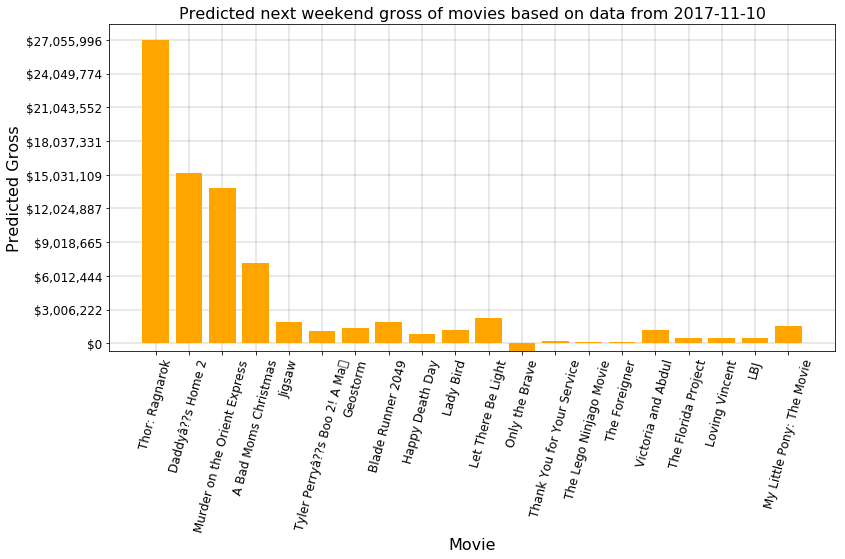

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from re import sub
from decimal import Decimal

# read the dataset representing a single weekend at the box-office 
# predictions will be made on each row in this dataset
data = pd.read_csv('box_office_next_week_dataset.csv', sep=',',header=0,encoding='ISO-8859-1')

# hit the web-service to get the predictions for each movie
movies = data['movie']
preds = []
for a in range(0, data.shape[0]-1):
    values = data.iloc[[a]].values[0]
    vals = []
    for b in values:
        val = str(b)
        if '$' in val:
            val = str(Decimal(sub(r'[^\d.]', '', val)))
            
        vals.append(val)
    

    preds.append(get_prediction(vals))

    
# number of data points on x axis
ind = np.arange(data.shape[0]) 

# single bar chart with the predicted revenue for each movie
fig, ax = plt.subplots()
ind = np.arange(len(preds)) 
preds = [float(numeric_string) for numeric_string in preds]
rects2 = ax.bar(ind, preds, color='orange', zorder = 3)

# set the size of the resulting graph
fig.set_size_inches(13, 6, forward=True)

# axis labels
plt.ylabel('Predicted Gross',fontsize=16)
plt.xlabel('Movie',fontsize=16)
plt.title('Predicted next weekend gross of movies based on data from ' + data['date'][0],fontsize=16)

# tick labels
y=[]
yticks=[]
count = 0 #np.amin(preds);
max = np.amax(preds) 
interval = max/9
for i in range(1, 11):
    yticks.append('${:,.0f}'.format(count))
    y.append(count)
    count = count+interval
    
plt.xticks(ind, movies, fontsize=12)
plt.yticks(y, yticks, fontsize=12)
for tick in ax.get_xticklabels():
    tick.set_rotation(75)

# create grid marks within the graph
plt.grid(color='#696969', linestyle='-', linewidth=.3, zorder = 0)

# display graph
plt.show()